## Simple Stellar Population (SSP)
Here we will explain the central routine of **Chempy**. The observational counterpart of an SSP is the open cluster. All stars are approximately born at the same time, and from the same ISM abundances. Therefore the SSP is characterized by its total **mass**, its birth **age** and its **initial elemental composition**. When assuming **stellar lifetimes**, an **IMF** and **nucleosynthetic feedback** we can calculate its feedback over time.
You will see how this is realized in Chempy.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../source/

/home/jan/Arbeitsfläche/Chempy_git/source


In [3]:
# Chempy has to be called from within the /source directory. We load the default parameters

from parameter import ModelParameters
a = ModelParameters()

First we load the default values of:
- IMF
- SN2, AGB and SNIa feedback

In [4]:
# Load the IMF

from imf import IMF
basic_imf = IMF(a.mmin,a.mmax,a.mass_steps)
getattr(basic_imf, a.imf_type_name)((a.chabrier_para1,a.chabrier_para2,a.chabrier_para3,a.high_mass_slope))

# Load the yields of the default yield set

from yields import SN2_feedback
from yields import AGB_feedback
from yields import SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, "Nomoto2013")()
basic_1a = SN1a_feedback()
getattr(basic_1a, "Seitenzahl")()
basic_agb = AGB_feedback()
getattr(basic_agb, "Karakas_net_yield")()

We check how many elements are traced by our yield set

In [5]:
# Print all supported elements

elements_to_trace = list(np.unique(basic_agb.elements+basic_sn2.elements+basic_1a.elements))
print(elements_to_trace)

['Al', 'Ar', 'B', 'Be', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ne', 'Ni', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V', 'Zn']


When initialising the SSP class, we have to make the following choices(in brackets our choices are given):

- Which metallicity does it have (Solar)
- How long will the SSP live and at which timesteps do we want the feedback to be evaluated (Delta t = 0.025 for 13.5 Gyr)
- What is the lifetime rroutine (Argast+ 2000)
- How should the interpolation in metallicity from the yield tables be (logarithmic)
- Do we want to safe the net yields as well (No)


In [6]:
# Load solar abundances

from solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()


# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,541)
from weighted_yield import SSP
basic_ssp = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 


This initialises the SSP class. It calculates the inverse IMF (stars of which minimal mass will be dead until each time-step) and it also initialises the feedback table, which need to be filled by the feedback from each subroutine, representing a specific nucleosynthetic process (CC-SN, AGB star, SN Ia). For the inverse IMF's first time-steps we see that only after the first and second time-step CC-SN will contribute (only stars smaller than 8Msun survive longer...).

(0.0, ' Gyr -->', 100.0, ' Msun')
(0.025000000000000001, ' Gyr -->', 10.438485737832705, ' Msun')
(0.050000000000000003, ' Gyr -->', 7.1643512642595777, ' Msun')
(0.075000000000000011, ' Gyr -->', 5.8789678259056384, ' Msun')
(0.10000000000000001, ' Gyr -->', 5.1492879408750047, ' Msun')


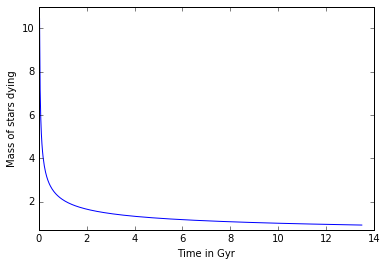

In [7]:
# Plotting the inverse IMF

plt.plot(time_steps[1:],basic_ssp.inverse_imf[1:])
plt.ylabel('Mass of stars dying')
plt.xlabel('Time in Gyr')
plt.ylim((0.7,11))
for i in range(5):
    print(time_steps[i], ' Gyr -->', basic_ssp.inverse_imf[i], ' Msun')

In order to calculate the feedback for the CC-SN and AGB star we will need to provide the elemental abundances at birth, for which we will use solar abundances for now. (This is the case for net yields, gross yields already include the initial stellar abundance that will be expelled.)

In [8]:
# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

In [9]:
# Each nucleosynthetic process has its own method on the SSP class and adds its feedback into the final table

basic_ssp.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
basic_ssp.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
basic_ssp.sn1a_feedback(list(basic_1a.elements), list(basic_1a.metallicities), dict(basic_1a.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), a.stochastic_IMF)

### Elemental feedback from an SSP over time

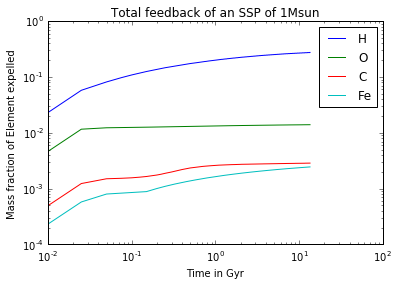

In [10]:
# Now we can plot the feedback of an SSP over time for a few elements

plt.plot(time_steps,np.cumsum(basic_ssp.table['H']), label = 'H')
plt.plot(time_steps,np.cumsum(basic_ssp.table['O']), label = 'O')
plt.plot(time_steps,np.cumsum(basic_ssp.table['C']), label = 'C')
plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = 'Fe')
#plt.plot(time_steps,basic_ssp.sn2_table['O'], label = 'O net yield')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction of Element expelled')
plt.title('Total feedback of an SSP of 1Msun')
plt.xlabel('Time in Gyr')
plt.legend()

### The difference between different yield sets

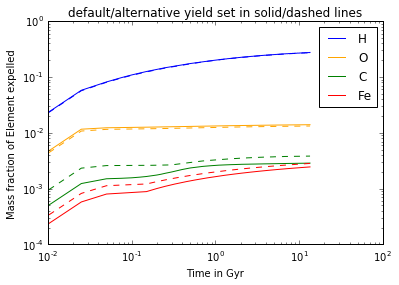

In [11]:
# Loading an SSP which uses the alternative yield set

basic_ssp_alternative = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 
basic_sn2_alternative = SN2_feedback()
getattr(basic_sn2_alternative, "chieffi04")()
basic_1a_alternative = SN1a_feedback()
getattr(basic_1a_alternative, "Thielemann")()
basic_agb_alternative = AGB_feedback()
getattr(basic_agb_alternative, "Ventura")()
basic_ssp_alternative.sn2_feedback(list(basic_sn2_alternative.elements), dict(basic_sn2_alternative.table), np.copy(basic_sn2_alternative.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
basic_ssp_alternative.agb_feedback(list(basic_agb_alternative.elements), dict(basic_agb_alternative.table), list(basic_agb_alternative.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
basic_ssp_alternative.sn1a_feedback(list(basic_1a_alternative.elements), list(basic_1a_alternative.metallicities), dict(basic_1a_alternative.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), a.stochastic_IMF)


# Plotting the difference

plt.plot(time_steps,np.cumsum(basic_ssp.table['H']), label = 'H', color = 'b')
plt.plot(time_steps,np.cumsum(basic_ssp.table['O']), label = 'O', color = 'orange')
plt.plot(time_steps,np.cumsum(basic_ssp.table['C']), label = 'C', color = 'g')
plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = 'Fe', color = 'r')
plt.plot(time_steps,np.cumsum(basic_ssp_alternative.table['H']), linestyle = '--', color = 'b')
plt.plot(time_steps,np.cumsum(basic_ssp_alternative.table['O']), linestyle = '--', color = 'orange')
plt.plot(time_steps,np.cumsum(basic_ssp_alternative.table['C']), linestyle = '--', color = 'g')
plt.plot(time_steps,np.cumsum(basic_ssp_alternative.table['Fe']), linestyle = '--', color = 'r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction of Element expelled')
plt.title('default/alternative yield set in solid/dashed lines')
plt.xlabel('Time in Gyr')
plt.legend()

### The contribution of different nucleosynthetic paths to a single element

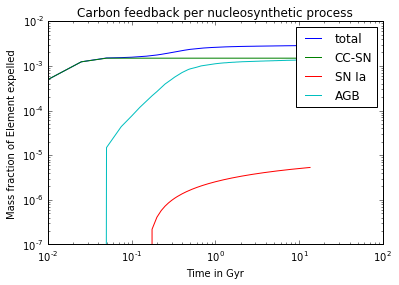

In [12]:
# The SSP class stores the individual feedback of each nucleosynthetic channel
# Here we plot the Carbon feedback over time

plt.plot(time_steps,np.cumsum(basic_ssp.table['C']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp.sn2_table['C']), label = 'CC-SN')
plt.plot(time_steps,np.cumsum(basic_ssp.sn1a_table['C']), label = 'SN Ia')
plt.plot(time_steps,np.cumsum(basic_ssp.agb_table['C']), label = 'AGB')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction of Element expelled')
plt.xlabel('Time in Gyr')
plt.title('Carbon feedback per nucleosynthetic process')
plt.legend()

### The number of events

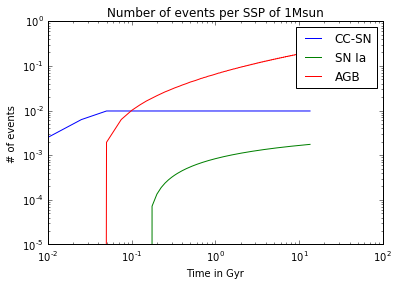

In [13]:
# The number of events is stored as well

plt.plot(time_steps,np.cumsum(basic_ssp.table['sn2']), label = 'CC-SN')
plt.plot(time_steps,np.cumsum(basic_ssp.table['sn1a']), label = 'SN Ia')
plt.plot(time_steps,np.cumsum(basic_ssp.table['pn']), label = 'AGB')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('# of events')
plt.xlabel('Time in Gyr')
plt.title('Number of events per SSP of 1Msun')
plt.legend()

### The mass fractions

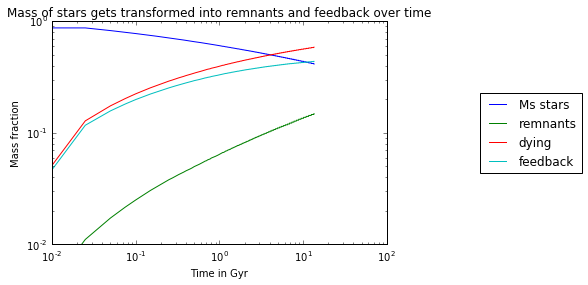

In [14]:
# As is the mass fraction of stars, remnants, dying stars from which the total feedback mass can be calculated

plt.plot(time_steps,basic_ssp.table['mass_in_ms_stars'], label = 'Ms stars')
plt.plot(time_steps,np.cumsum(basic_ssp.table['mass_in_remnants']), label = 'remnants')
plt.plot(time_steps,np.cumsum(basic_ssp.table['mass_of_ms_stars_dying']), label = 'dying')
plt.plot(time_steps,np.cumsum(basic_ssp.table['mass_of_ms_stars_dying']) - np.cumsum(basic_ssp.table['mass_in_remnants']), label = 'feedback')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction')
plt.xlabel('Time in Gyr')
plt.title('Mass of stars gets transformed into remnants and feedback over time')
plt.legend(loc = 'right', bbox_to_anchor= (1.6,0.5))

## IMF weighted yield of an SSP 
- Depends on the timespan over which we integrate (here we use the full 13.5Gyr)
- Depends on the IMF
- On the chosen yield set
- The mass range of the nucleosynthetic process (e.g. low-mass CC-SN have only solar alpha/Fe abundances)
- etc... play around and investigate

In [15]:
# Here we print the time-integrated yield of an SSP (feedback after 13,5Gyr)
# for different elements and also for CC-SNe feedback only

normalising_element = 'Fe'
print('alternative yield set')
print('Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)')
for element in ['C', 'O', 'Mg', 'Ca', 'Mn', 'Ni']:
    element_ssp_sn2 = sum(basic_ssp_alternative.sn2_table[element])
    element_ssp = sum(basic_ssp_alternative.table[element])
    element_sun = basic_solar.fractions[np.where(elements == element)]
    normalising_element_ssp_sn2 = sum(basic_ssp_alternative.sn2_table[normalising_element])
    normalising_element_ssp = sum(basic_ssp_alternative.table[normalising_element])
    normalising_element_sun = basic_solar.fractions[np.where(elements == normalising_element)]
    print(element, np.log10(element_ssp/element_sun)-np.log10(normalising_element_ssp/normalising_element_sun), np.log10(element_ssp_sn2/element_sun)-np.log10(normalising_element_ssp_sn2/normalising_element_sun))
print('------------------------------------------')
print('default yield set')
print('Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)')
for element in ['C', 'O', 'Mg', 'Ca', 'Mn', 'Ni']:
    element_ssp_sn2 = sum(basic_ssp.sn2_table[element])
    element_ssp = sum(basic_ssp.table[element])
    element_sun = basic_solar.fractions[np.where(elements == element)]
    normalising_element_ssp_sn2 = sum(basic_ssp.sn2_table[normalising_element])
    normalising_element_ssp = sum(basic_ssp.table[normalising_element])
    normalising_element_sun = basic_solar.fractions[np.where(elements == normalising_element)]
    print(element, np.log10(element_ssp/element_sun)-np.log10(normalising_element_ssp/normalising_element_sun), np.log10(element_ssp_sn2/element_sun)-np.log10(normalising_element_ssp_sn2/normalising_element_sun))

alternative yield set
Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)
('C', array([-0.13114334]), array([ 0.10377963]))
('O', array([ 0.02348811]), array([ 0.36715726]))
('Mg', array([-0.13455906]), array([ 0.1718083]))
('Ca', array([-0.11044523]), array([ 0.09744231]))
('Mn', array([-0.00451402]), array([-0.01990174]))
('Ni', array([ 0.29423482]), array([ 0.15736106]))
------------------------------------------
default yield set
Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)
('C', array([-0.19445142]), array([ 0.01555086]))
('O', array([ 0.10937471]), array([ 0.54719255]))
('Mg', array([-0.04278569]), array([ 0.35500187]))
('Ca', array([-0.03516263]), array([ 0.24030457]))
('Mn', array([ 0.16472003]), array([-0.26083037]))
('Ni', array([ 0.13933476]), array([-0.07825312]))


### Net yield vs. gross yield
Here the difference between newly produced material (net yield) and total expelled material (gross yield) is shown for AGB and CC-SN.

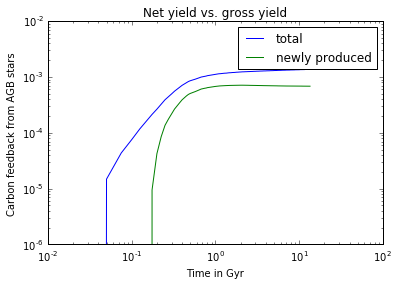

In [16]:
# We can set the the additional table (e.g. agb_table) to only save the newly produced material

basic_ssp_net = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', True) 
basic_ssp_net.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))

# And then compare these net yields to gross yields for C

plt.plot(time_steps,np.cumsum(basic_ssp.agb_table['C']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp_net.agb_table['C']), label = 'newly produced')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Carbon feedback from AGB stars')
plt.xlabel('Time in Gyr')
plt.title('Net yield vs. gross yield')
plt.legend()

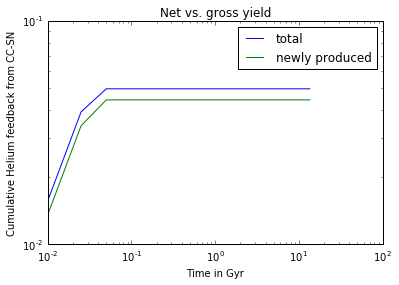

In [17]:
# And show the same for O and CC-SNe

basic_ssp_net = SSP(False, basic_solar.z, basic_imf.x, basic_imf.dm, basic_imf.dn, time_steps, elements_to_trace, 'Argast_2000', 'logarithmic', True)
basic_ssp_net.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
plt.plot(time_steps,np.cumsum(basic_ssp.sn2_table['He']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp_net.sn2_table['He']), label = 'newly produced')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Cumulative Helium feedback from CC-SN')
plt.xlabel('Time in Gyr')
plt.title('Net vs. gross yield')
plt.legend()

## Stochastic IMF sampling
- The feedback and the explosion of SN Ia can also be calculated stochastically.
- The mass of the SSP needs to be provided (the feedback table is given in fractions).
- Each realisation will be new (you can check by redoing the plot).

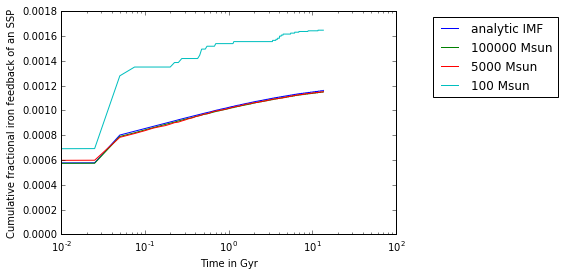

In [18]:
# The IMF can be sampled stochastically. First we plot the analytic version 

basic_imf = IMF(a.mmin,a.mmax,a.mass_steps)
getattr(basic_imf, a.imf_type_name)((a.chabrier_para1,a.chabrier_para2,a.chabrier_para3,a.high_mass_slope))
basic_ssp = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 
basic_ssp.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
basic_ssp.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
basic_ssp.sn1a_feedback(list(basic_1a.elements), list(basic_1a.metallicities), dict(basic_1a.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), True)
plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = 'analytic IMF')


# Then we add the stochastic sampling for 3 different masses

for mass in [1e5,5e3,1e2]:
    basic_imf = IMF(a.mmin,a.mmax,a.mass_steps)
    getattr(basic_imf, a.imf_type_name)((a.chabrier_para1,a.chabrier_para2,a.chabrier_para3,a.high_mass_slope))
    basic_imf.stochastic_sampling(mass)
    basic_ssp = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 
    basic_ssp.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
    basic_ssp.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
    basic_ssp.sn1a_feedback(list(basic_1a.elements), list(basic_1a.metallicities), dict(basic_1a.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), True)
    plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = '%d Msun' %(mass))
plt.xscale('log')
plt.ylabel('Cumulative fractional iron feedback of an SSP')
plt.xlabel('Time in Gyr')
plt.legend(bbox_to_anchor = (1.5,1))

## SSP wrapper
In order to query the SSP feedback faster and easier we write a little wrapper in wrapper.py and look at the imf weighted yield change with IMF. We compare the bottom-heavy Kroupa IMF with the Salpeter IMF (which has more high-mass stars). We see that the total SSP yield changes quite drastically.

In [19]:
# Here we show the functionality of the wrapper, which makes the SSP calculation easy.
# We want to show the differences of the SSP feedback for 2 IMFs and load Kroupa first

a.only_net_yields_in_process_tables = False
a.imf_type_name = 'normed_3slope'
a.imf_parameter = (-1.3,-2.2,-2.7,0.5,1.0)

# The feedback can now be calculated by just typing the next three lines

from wrapper import SSP_wrap
basic_ssp = SSP_wrap(a)
basic_ssp.calculate_feedback(float(basic_solar.z),list(elements_to_trace),list(solar_fractions),np.copy(time_steps))


# We print the Kroupa IMF feedback

print('Kroupa IMF')
print('Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)')
for element in ['C', 'O', 'Mg', 'Ca', 'Mn', 'Ni']:
    element_ssp_sn2 = sum(basic_ssp.sn2_table[element])
    element_ssp = sum(basic_ssp.table[element])
    element_sun = basic_solar.fractions[np.where(elements == element)]
    normalising_element_ssp_sn2 = sum(basic_ssp.sn2_table[normalising_element])
    normalising_element_ssp = sum(basic_ssp.table[normalising_element])
    normalising_element_sun = basic_solar.fractions[np.where(elements == normalising_element)]
    print(element, np.log10(element_ssp/element_sun)-np.log10(normalising_element_ssp/normalising_element_sun), np.log10(element_ssp_sn2/element_sun)-np.log10(normalising_element_ssp_sn2/normalising_element_sun))

# Change to Salpeter    

a.imf_type_name = 'salpeter'
a.imf_parameter = (2.35)


# Calculate the SSP feedback

basic_ssp = SSP_wrap(a)
basic_ssp.calculate_feedback(float(basic_solar.z),list(elements_to_trace),list(solar_fractions),np.copy(time_steps))


# And print the feedback for comparison

print('Salpeter IMF')
print('Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)')
for element in ['C', 'O', 'Mg', 'Ca', 'Mn', 'Ni']:
    element_ssp_sn2 = sum(basic_ssp.sn2_table[element])
    element_ssp = sum(basic_ssp.table[element])
    element_sun = basic_solar.fractions[np.where(elements == element)]
    normalising_element_ssp_sn2 = sum(basic_ssp.sn2_table[normalising_element])
    normalising_element_ssp = sum(basic_ssp.table[normalising_element])
    normalising_element_sun = basic_solar.fractions[np.where(elements == normalising_element)]
    print(element, np.log10(element_ssp/element_sun)-np.log10(normalising_element_ssp/normalising_element_sun), np.log10(element_ssp_sn2/element_sun)-np.log10(normalising_element_ssp_sn2/normalising_element_sun))

Kroupa IMF
Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)
('C', array([-0.32372351]), array([-0.04899912]))
('O', array([-0.07550641]), array([ 0.49041114]))
('Mg', array([-0.20643796]), array([ 0.30501324]))
('Ca', array([-0.13817342]), array([ 0.16954995]))
('Mn', array([ 0.20630872]), array([-0.33799485]))
('Ni', array([ 0.17670711]), array([-0.02987776]))
Salpeter IMF
Element, total SSP yield, CC-SN yield ([X/Fe] i.e. normalised to solar)
('C', array([-0.31873905]), array([-0.01374845]))
('O', array([ 0.10167535]), array([ 0.58380394]))
('Mg', array([-0.07934627]), array([ 0.37154707]))
('Ca', array([-0.09149007]), array([ 0.19399203]))
('Mn', array([ 0.18548835]), array([-0.32610437]))
('Ni', array([ 0.17057456]), array([-0.01551558]))
